In [28]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings(action='ignore')

print(tf.__version__)

2.17.1


In [40]:
from google.colab import drive
import os

drive.mount('/content/drive')

DATA_DIR = '/content/drive/MyDrive/data/chest_xray'

print(f"Data directory: {DATA_DIR}")
print(os.listdir(DATA_DIR))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Data directory: /content/drive/MyDrive/data/chest_xray
['test', 'train', 'val']


In [61]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
TRAIN_PATH = DATA_DIR + '/train/*/*' # *은 모든 디렉토리와 파일을 의미합니다.
VAL_PATH = DATA_DIR + '/val/*/*'
TEST_PATH = DATA_DIR + '/test/*/*'

# # 프로젝트를 진행할 때 아래 두 변수를 변경해보세요
BATCH_SIZE = 32
EPOCHS = 20

In [62]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

4187
624
0


In [63]:
# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

3349
838


In [64]:
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[100]}')

Normal image path
/content/drive/MyDrive/data/chest_xray/train/PNEUMONIA/person319_bacteria_1475.jpeg
Pneumonia image path
/content/drive/MyDrive/data/chest_xray/train/PNEUMONIA/person329_virus_682.jpeg


In [65]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")


COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 260
Pneumonia images count in training set: 3089


In [66]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [67]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 3349
Validating images count: 838


In [68]:
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

In [84]:
# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    label = tf.cast(label, tf.int32)
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

In [85]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [86]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  1


In [87]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


In [88]:
def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

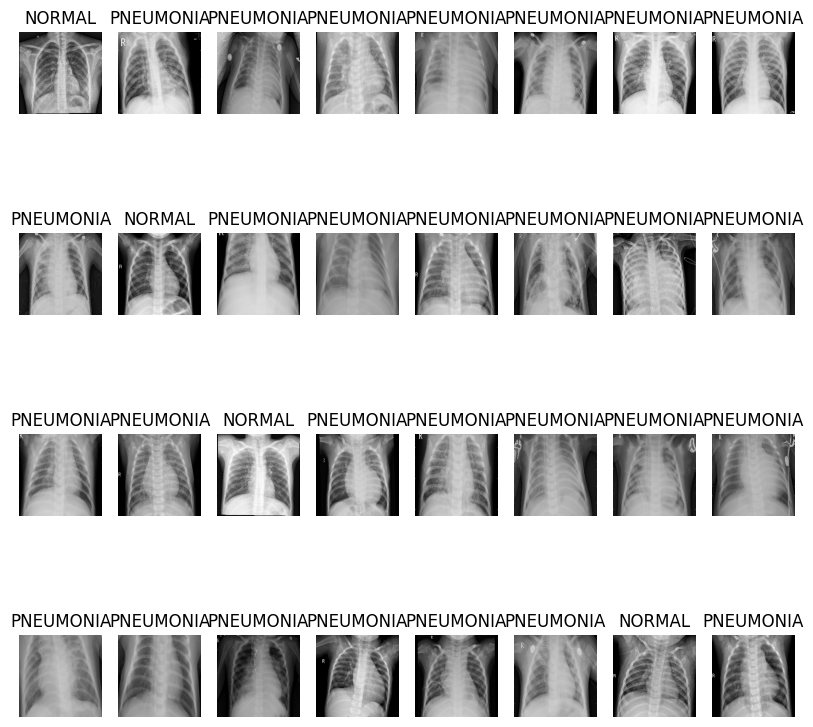

In [89]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

In [90]:
def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)  # 위아래 반전
    image = tf.image.random_brightness(image, max_delta=0.1)  # 밝기 조정
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)  # 대비 조정
    return image, label

In [75]:
# def conv_block(filters):
#     block = tf.keras.Sequential([
#         tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
#         tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
#         tf.keras.layers.BatchNormalization(),
#         tf.keras.layers.MaxPool2D()
#     ])

#     return block

In [56]:
# def dense_block(units, dropout_rate):
#     block = tf.keras.Sequential([
#         tf.keras.layers.Dense(units, activation='relu'),
#         tf.keras.layers.BatchNormalization(),
#         tf.keras.layers.Dropout(dropout_rate)
#     ])

#     return block

In [91]:
class ResidualBlock(tf.keras.Model):
    def __init__(self, filters, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = tf.keras.layers.Conv2D(filters, 3, strides=stride, padding='same', activation='relu')
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.conv2 = tf.keras.layers.Conv2D(filters, 3, strides=1, padding='same', activation='relu')
        self.bn2 = tf.keras.layers.BatchNormalization()
        self.downsample = None

        if stride != 1:
            self.downsample = tf.keras.Sequential([
                tf.keras.layers.Conv2D(filters, 1, strides=stride, activation=None, padding='same'),
                tf.keras.layers.BatchNormalization()
            ])

    def call(self, inputs, training=False):
        shortcut = inputs
        if self.downsample is not None:
            shortcut = self.downsample(shortcut)
        x = self.conv1(inputs)
        x = self.bn1(x, training=training)
        x = self.conv2(x)
        x = self.bn2(x, training=training)
        x += shortcut
        return tf.nn.relu(x)


In [57]:
# def build_model():
#     model = tf.keras.Sequential([
#         tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),

#         tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
#         tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
#         tf.keras.layers.MaxPool2D(),

#         conv_block(32),
#         conv_block(64),

#         conv_block(128),
#         tf.keras.layers.Dropout(0.2),

#         conv_block(256),
#         tf.keras.layers.Dropout(0.2),

#         tf.keras.layers.Flatten(),
#         dense_block(512, 0.7),
#         dense_block(128, 0.5),
#         dense_block(64, 0.3),

#         tf.keras.layers.Dense(1, activation='sigmoid')
#     ])

#     return model

In [92]:
def build_resnet18():
    inputs = tf.keras.layers.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))

    # Initial Conv Layer
    x = tf.keras.layers.Conv2D(64, 7, strides=2, padding='same', activation='relu')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same')(x)

    # Residual Blocks
    x = ResidualBlock(64)(x)
    x = ResidualBlock(64)(x)
    x = ResidualBlock(128, stride=2)(x)
    x = ResidualBlock(128)(x)
    x = ResidualBlock(256, stride=2)(x)
    x = ResidualBlock(256)(x)
    x = ResidualBlock(512, stride=2)(x)
    x = ResidualBlock(512)(x)

    # Average Pooling and Fully Connected Layer
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

    return tf.keras.Model(inputs, outputs)

model = build_resnet18()


In [93]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 6.44
Weight for PNEUMONIA: 0.54


In [94]:
from tensorflow.keras.optimizers import Adam, SGD

optimizer = Adam(learning_rate=1e-4)  # 또는 SGD(learning_rate=1e-3, momentum=0.9)

In [ ]:
with tf.device('/GPU:0'):
    model = build_resnet18()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]

    model.compile(
        # optimizer='adam',
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [ ]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 422s 4s/step - accuracy: 0.5548 - loss: 0.7753 - precision: 0.9513 - recall: 0.5451 - val_accuracy: 0.9375 - val_loss: 0.6015 - val_precision: 0.9375 - val_recall: 1.0000
Epoch 2/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 332s 3s/step - accuracy: 0.6233 - loss: 0.5949 - precision: 0.9829 - recall: 0.6036 - val_accuracy: 0.9375 - val_loss: 0.5437 - val_precision: 0.9375 - val_recall: 1.0000
Epoch 3/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 325s 3s/step - accuracy: 0.6545 - loss: 0.5518 - precision: 0.9880 - recall: 0.6314 - val_accuracy: 0.9387 - val_loss: 0.4845 - val_precision: 0.9387 - val_recall: 1.0000
Epoch 4/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 347s 3s/step - accuracy: 0.6806 - loss: 0.4860 - precision: 0.9941 - recall: 0.6571 - val_accuracy: 0.9411 - val_loss: 0.4188 - val_precision: 0.9411 - val_recall: 1.0000
Epoch 5/20
 88/104 ━━━━━━━━━━━━━━━━━━━━ 46s 3s/step - accuracy: 0.7175 - loss: 0.4428 - precision: 0.9957 - recall: 0.6982

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [ ]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

In [ ]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

plot_history(history)
